# RNA-seq Analysis for Angeles and Leighton, 2016. 

We used Kallisto to map reads and estimate TPM counts and Sleuth to analyze the RNA-seq data. 

However, because I like to make my own plots, and because I wanted to carry out extensive analysis (I mainly write in python), the results were transferred from R into this python pipeline.

This pipeline is built using Python > 3.5

Requirements:

pandas
numpy
matplotlib.pyplot

tissue_enrichment analysis (`pip install tissue_enrichment_analysis` to get it; publication forthcoming)

pyrnaseq_graphics (found in our [github repository](https://github.com/WormLabCaltech/Angeles_And_Leighton_2016), publication may be forthcoming)



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tissue_enrichment_analysis as tea
import pyrnaseq_graphics as rsq
import scipy.stats as stats
import matplotlib as mpl

from IPython.core.display import HTML


# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html

# Display graphics in this notebook
bokeh.io.output_notebook()


Loading BokehJS ...

In [2]:
%matplotlib inline

# This enables high res graphics inline (only use with static plots (non-Bokeh))
# SVG is preferred, but there is a bug in Jupyter with vertical lines
%config InlineBackend.figure_formats = {'png', 'retina'}

# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('png')
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 22, 
      'axes.titlesize': 20, 
      'legend.fontsize': 'x-large',
      'axes.facecolor': 'DFDFE5'}
sns.set_context('paper', rc=rc)
sns.set_style('dark', rc=rc)

import matplotlib.cm as cm
from matplotlib import rc
rc('text', usetex=True)
import matplotlib.patheffects as path_effects


mag = 2  # value of beta from regression
qval = .1  # qvalue from regression
qvalEn = 0.05  # q value for enrichment analysis (tissues)


# Importing Data and a Brief Reminder of Sleuth Results

First, I load all my data. Briefly, remember that Sleuth calculates log-linear models of the form 

$$
log(y_i) = \beta_0 + \sum\limits_{k\epsilon K}\beta_k \cdot x_k + \sum\limits_{k\epsilon K}\sum\limits_{l\epsilon L} \beta_{k, l} \cdot x_k \cdot x_l + ...
$$

and these linear models can be extended to have interactions, etc.. 

For our specific model, we chose a linear model with interactions, of the form:

$$
log(y_i) = \beta_0 + \beta_{\mathrm{Old Adult}} \cdot x_{\mathrm{Old Adult}} + \beta_{\mathrm{fog-2}} \cdot x_{\mathrm{fog-2}} + \beta_{\mathrm{fog-2, Old Adult}} \cdot x_{\mathrm{fog-2}} \cdot x_{\mathrm{Old Adult}} 
$$

In [10]:
output_aging = '../output/raw_aging_plots/'
output_genotype = '../output/raw_genotype_plots/'
output_interaction = '../output/raw_interaction_plots/'
output_sperm = '../output/raw_sperm_plots/'

# gene_lists from sleuth
# tpm vals for PCA
path = '../input/sleuth_results/'
# pos beta means high old adults
dfBetaA = pd.read_csv(path + "agebeta_wt.csv")
dfBetaA.dropna(inplace=True)
# pos beta means high in fog2
dfBetaG = pd.read_csv(path + "genotypebeta_wt.csv")
dfBetaG.dropna(inplace=True)
# pos beta means high in fog2-aged
dfBetaAG = pd.read_csv(path + "genotypecrossagebeta_wt.csv")
dfBetaAG.dropna(inplace=True)
# likelihood ratio test results
dfLRT = pd.read_csv(path + "lrt.csv")
dfLRT.dropna(inplace=True)

# sort by target_id
dfBetaA.sort_values('target_id', inplace=True)
dfBetaA.reset_index(inplace=True)
dfBetaG.sort_values('target_id', inplace=True)
dfBetaG.reset_index(inplace=True)
dfBetaAG.sort_values('target_id', inplace=True)
dfBetaAG.reset_index(inplace=True)
dfLRT.sort_values('target_id', inplace=True)
dfLRT.reset_index(inplace=True)

# gold standard datasets
path = '../input/gold_standards/'
dfDaf12 = pd.read_csv(path + 'daf12genes.csv')
dfDaf16 = pd.read_csv(path + 'daf16genes.csv')
dfLund = pd.read_csv(path + 'lund_data.csv', header=None, names=['gene'])
dfEckley = pd.read_csv(path + 'eckley_data.csv', header=None, names=['gene'])
dfMurphyUp = pd.read_csv(path + 'murphy_data_lifespan_extension.csv')
dfMurphyDown = pd.read_csv(path + 'murphy_data_lifespan_decrease.csv')
dfHalaschek = pd.read_csv(path + 'Halaschek-Wiener_data.csv')

# gpcrs
dfGPCR = pd.read_csv(path + 'all_gpcrs.csv')
dfICh = pd.read_csv(path + 'select_ion_transport_genes.csv')
dfAxon = pd.read_csv(path + 'axonogenesis_genes.csv')
dfNP = pd.read_csv(path + 'neuropeptides.csv')

# gpcr is going to go into a gold standard fxn so add an 'origin' colmn
dfGPCR['origin'] = 'gpcrs'
dfICh['origin'] = 'select ion transport genes'
dfAxon['origin'] = 'axonogenesis genes'
dfNP['origin'] = 'neuropeptide genes'
frames = [dfGPCR, dfICh, dfAxon, dfNP]
dfTargets = pd.concat(frames)

dfTargets.columns = ['gene', 'effect']

# place all the gold standards in a single dataframe:
dfDaf12['origin'] = 'daf-12'
dfDaf16['origin'] = 'daf-16'
dfEckley['origin'] = 'Eckley'
dfLund['origin'] = 'Lund'
dfMurphyUp['origin'] = 'MurphyExt'
dfMurphyDown['origin'] = 'MurphyDec'
dfHalaschek['origin'] = 'Halaschek'
frames = [dfDaf12, dfDaf16, dfEckley, dfLund,
          dfMurphyDown, dfMurphyUp, dfHalaschek]
dfGoldStandard = pd.concat(frames)

# from wormbase
dfLifespanGenes = pd.read_csv(path + 'lifespan gene list complete.csv')

tissue_df = tea.fetch_dictionary()
phenotype_df = pd.read_csv('../input/phenotypes_dict.csv')

tf = pd.read_csv('../input/tf_list.csv')
# go = pd.read_csv('../input/go.csv')

In [11]:
# sterility = pd.read_csv('~/Downloads/sterility genes.txt', header=None)
# sperm = pd.read_csv('~/Downloads/sperm genes by phenotype.txt', header=None)

path = '../input/sleuth_results/'
df_TPM = pd.read_csv(path + 'tpm_table.csv')

xticksize = 15.5
xlabelsize = 23
ylabelsize_volcano = 23
volcano_legendsize = 10

# Run TEA

Run tissue enrichment analysis to identify tissues most impacted by aging and genotype. We will run the analysis three times:
Once for genes that are differentially affected by aging, once for genes that are differentially affected by genotype, and once for genes that have significant interaction terms. 

In [12]:
print('Aging Results:')
resA, _ = tea.enrichment_analysis(dfBetaA[(dfBetaA.qval < qval)].ens_gene, tissue_df)
print('\n-------------\nGenotype Results:')
resG, _ = tea.enrichment_analysis(dfBetaG[(dfBetaG.qval < qval)].ens_gene, tissue_df)
print('\n-------------\nAging::Genotype Results:')
resAG, _ = tea.enrichment_analysis(dfBetaAG[(dfBetaAG.qval < qval)].ens_gene, tissue_df)

Aging Results:
Executing script

                               Tissue    Expected  Observed  \
4                pharynx WBbt:0003681  669.033794       774   
1            muscle cell WBbt:0003675  506.454545       596   
2  anal depressor muscle WBbt:0004292  158.175296       206   
3             hypodermis WBbt:0005733  550.494071       626   
0                    hmc WBbt:0004697   22.386759        34   

   Enrichment Fold Change       P value       Q value  
4                1.156892  8.605131e-11  2.228729e-08  
1                1.176808  2.305822e-09  2.986040e-07  
2                1.302353  3.212585e-07  2.773532e-05  
3                1.137160  6.752797e-07  4.372436e-05  
0                1.518755  7.569429e-04  3.920964e-02  

-------------
Genotype Results:
Executing script

                        Tissue    Expected  Observed  Enrichment Fold Change  \
1     muscle cell WBbt:0003675  190.636364       235                1.232713   
2  uterine muscle WBbt:0005342   18.23478

Make relevant plots using the inbuilt plotter in tea:

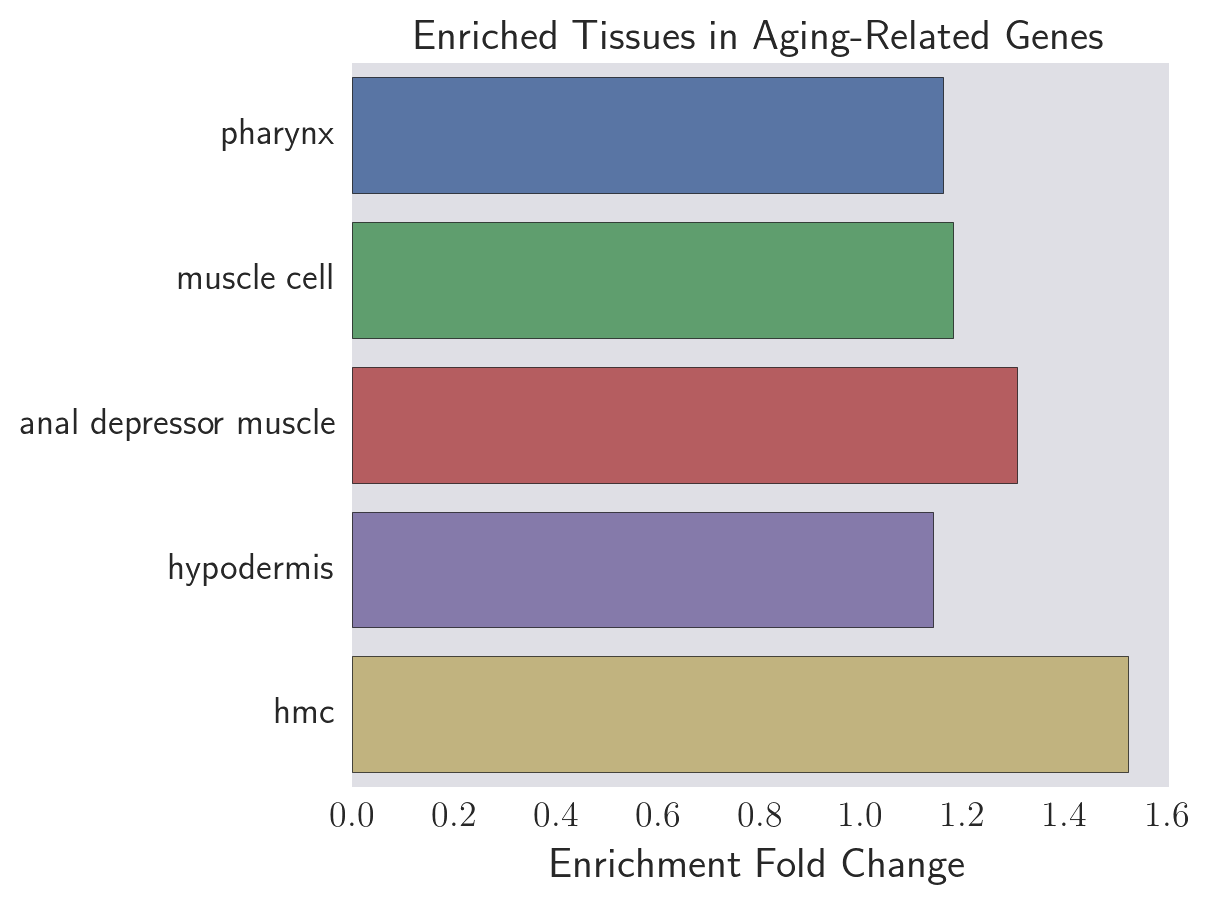

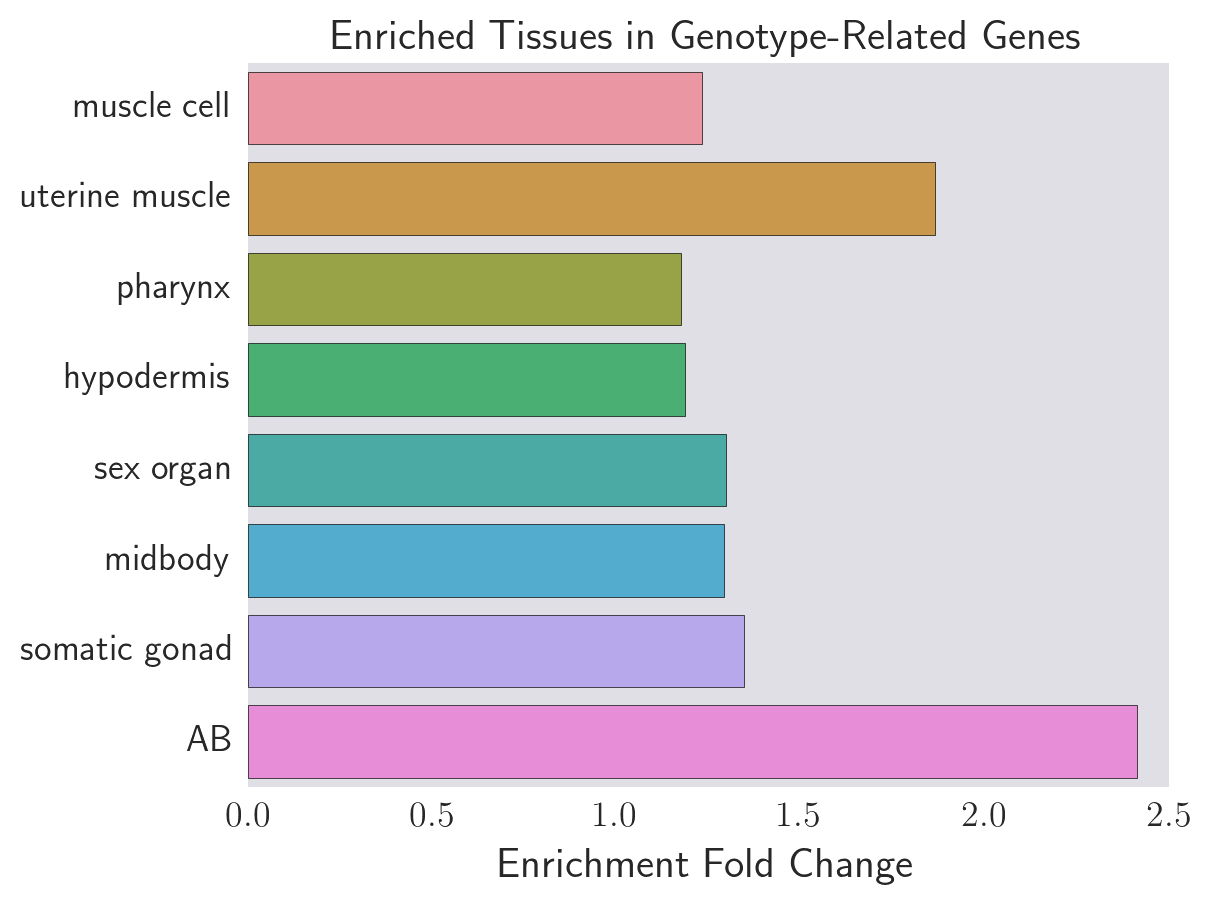

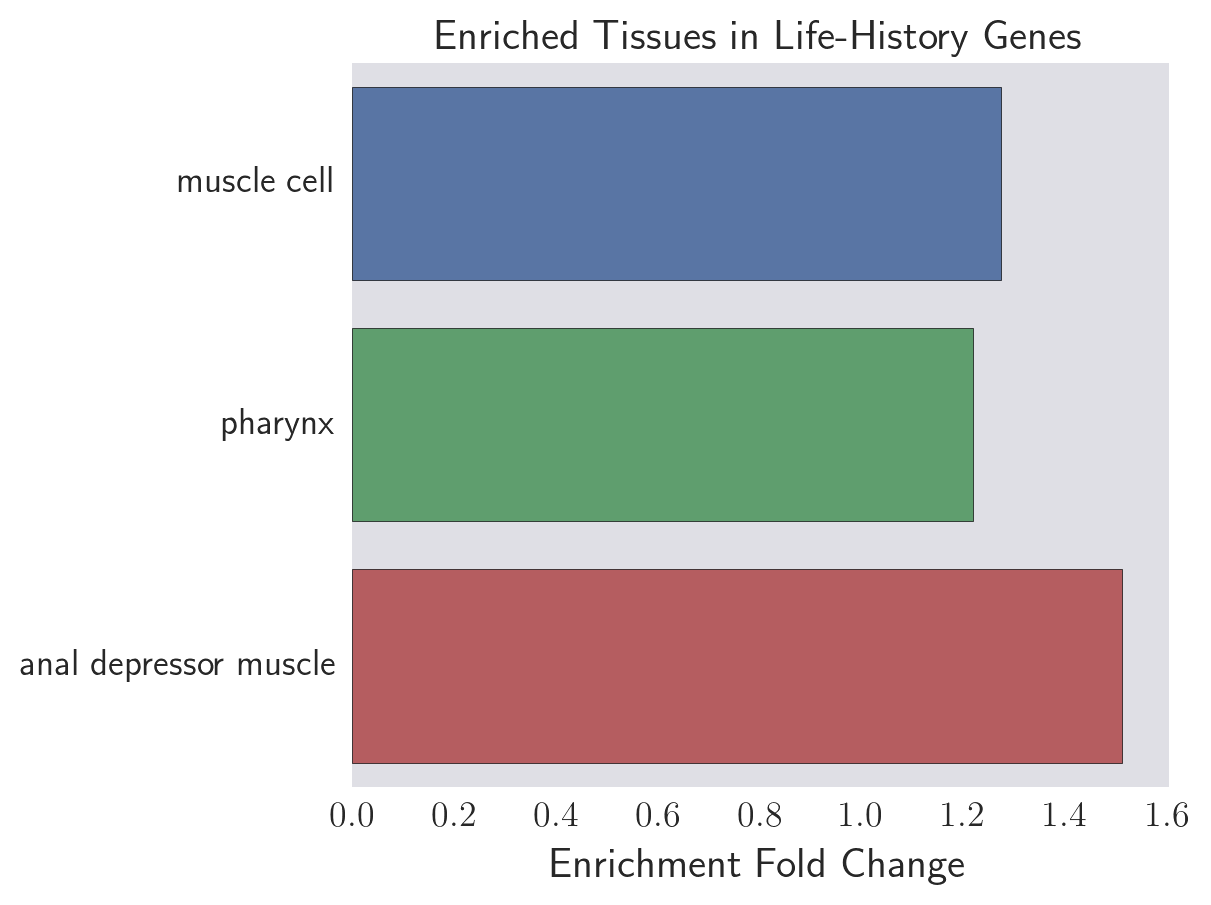

In [13]:
def fix_fonts(n, ax):
    if type(n) != int:
        raise ValueError('n must be an integer')
        
    ax.xaxis.label.set_fontsize(n)
    ax.yaxis.label.set_fontsize(n)
    ax.title.set_fontsize(n)


fig, ax = plt.subplots()
tea.plot_enrichment_results(resA, save=False)
plt.title('Enriched Tissues in Aging-Related Genes')
plt.ylabel('')
fix_fonts(15, ax)
plt.savefig(output_aging + 'tea_aging.svg', transparent=True)

fig, ax = plt.subplots()
tea.plot_enrichment_results(resG, save=False)
plt.title('Enriched Tissues in Genotype-Related Genes')
plt.ylabel('')
fix_fonts(15, ax)
plt.savefig(output_genotype + 'tea_genotype.svg', transparent=True)


fig, ax = plt.subplots()
tea.plot_enrichment_results(resAG, save=False)
plt.title('Enriched Tissues in Life-History Genes')
plt.ylabel('')
fix_fonts(15, ax)
plt.savefig(output_interaction + 'tea_interaction.svg', transparent=True)

TEA suggests that the muscle is heavily impacted by aging, which makes sense. Interestingly, the pharynx is most overrepresented, but neither of us have noticed pumping differences between old and young animals. Stratifying results by effect sign shows that upregulated genes are responsible for the enrichment of these terms, and genes that are downregulated have no statistically significant enrichment. 

Genotype TEA also yields sensible results. The terms 'uterine muscle', 'midbody', 'sex organ' and 'somatic gonad' all turn up, which reflect the nature of the genetic change caused by the fog-2 mutation, namely, loss of sperm. Interestingly, stratifying the analysis by effect sign (b > 0 or b < 0), shows that genes upregulated in fog-2 relative to N2 are mainly associated with germline/gonad/hypodermis, whereas downregulated genes are associated with muscles. 

Interestingly, running TEA on Life-History genes also suggests that certain muscles experience significantly different stresses between worms of different genotype. Stratified analyses show that genes with significantly negative interaction terms are mainly neuronally associated, whereas genes with significantly positive interactions terms show excretory cell and pharynx. 

# Tissue Specific KDE Plots

Given our TEA analysis, let's dig a bit deeper and quantify some of the changes we see in tissue expression. Arbitrarily, 

/Users/dangeles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


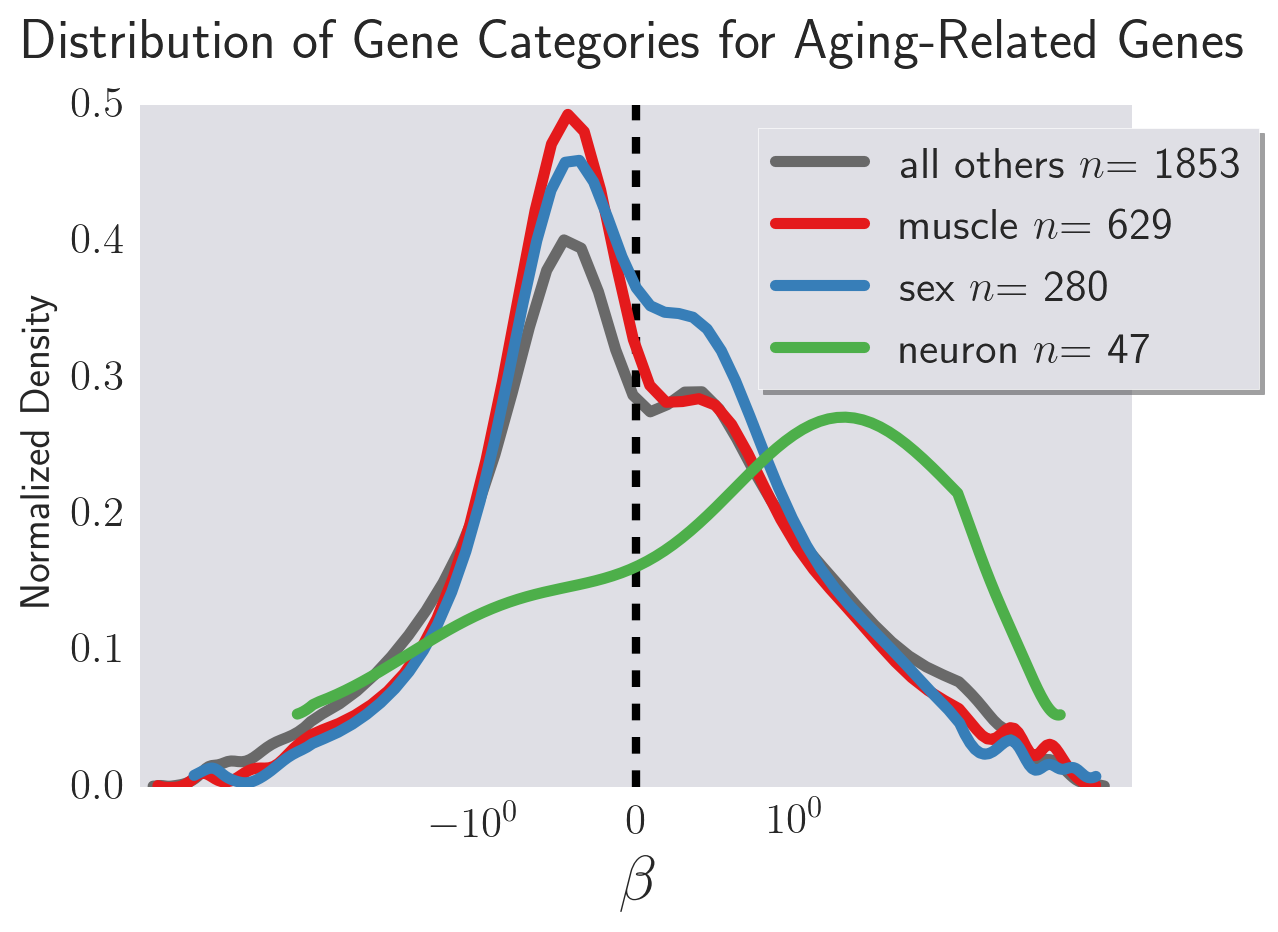

In [14]:
colors = ['#696969', '#e41a1c', '#377eb8',
          '#4daf4a', '#984ea3', '#ff7f00']
tissues = ['muscle', 'sex', 'neuron']
df_exp = rsq.organize(tissues, tissue_df)

genes = 'ens_gene'
x = 'b'
y = 'qval'

fig, ax = rsq.tissue_kegg(qval, genes, x, y,  dfBetaA, df_exp, colors=colors, ylab='Normalized Density')
plt.xscale('symlog')
title = plt.title('Distribution of Gene Categories for Aging-Related Genes', fontsize=20)
title.set_y(1.05)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=xticksize)
plt.xlabel(s=r'$\beta$',fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
plt.ylabel('Normalized Density').set_path_effects([path_effects.Normal()])
ax.legend(bbox_to_anchor=(1.15, 1), frameon=True, fontsize=16, shadow=True)
plt.savefig(output_aging + 'tissue_distribution.svg', bbox_inches='tight')

WOW! Neurons really shift, huh? Notice that $\beta$ is plotted on log scale, even though it itself is a log paramter. Some genes really change expression. 

/Users/dangeles/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


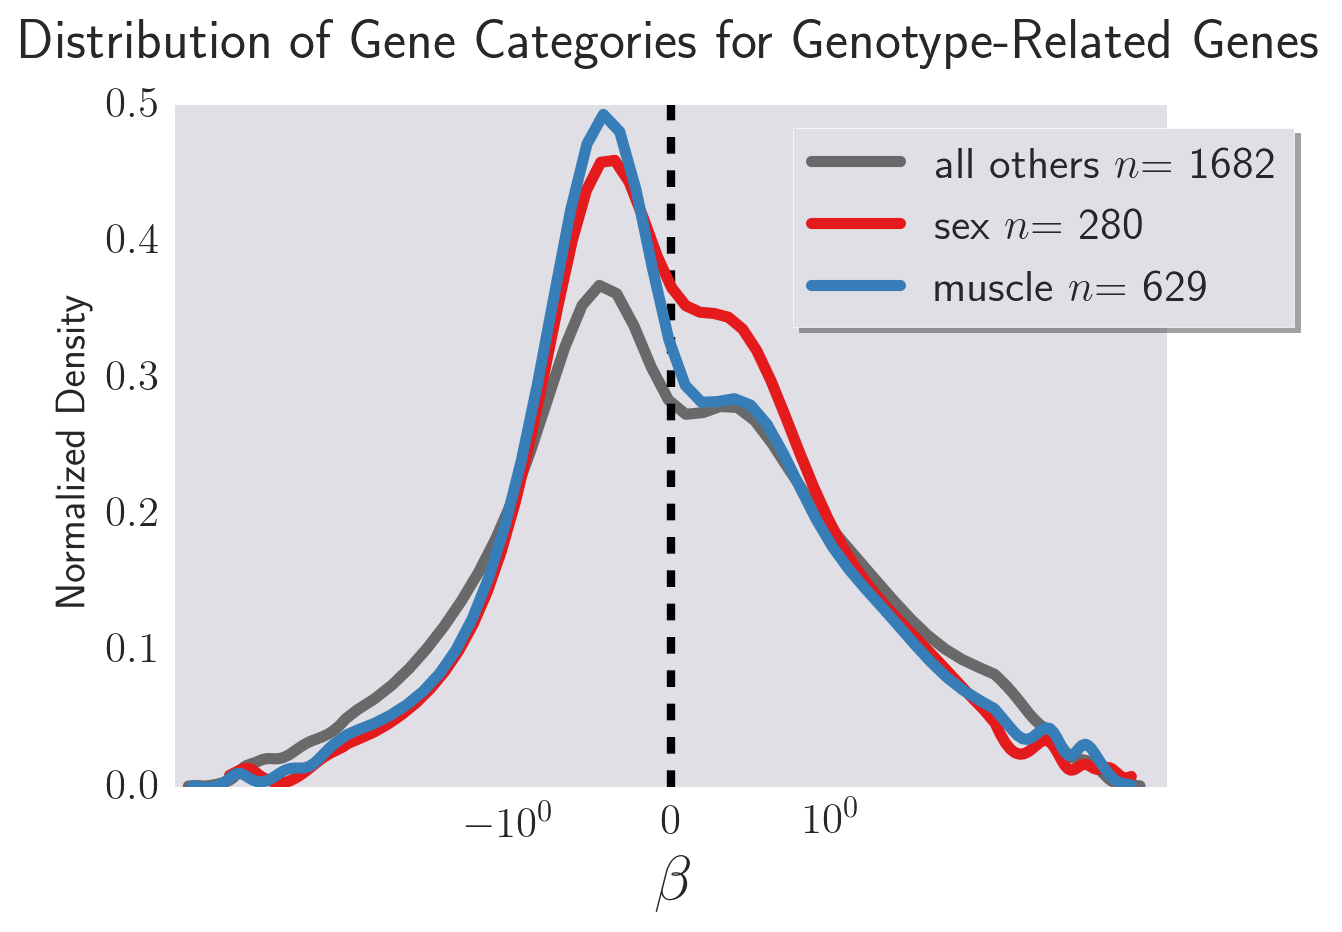

In [15]:
colors = ['#696969', '#e41a1c', '#377eb8',
          '#4daf4a', '#984ea3', '#ff7f00']
tissues = ['sex', 'muscle']
df_exp = rsq.organize(tissues, tissue_df)

fig, ax = rsq.tissue_kegg(qval, genes, x, y,  dfBetaA, df_exp, colors=colors, ylab='Normalized Density')
plt.xscale('symlog')
title = plt.title('Distribution of Gene Categories for Genotype-Related Genes')
title.set_y(1.05)
title.set_y(1.05)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=xticksize)
plt.xlabel(s=r'$\beta$',fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
plt.ylabel('Normalized Density').set_path_effects([path_effects.Normal()])
ax.legend(bbox_to_anchor=(1.15, 1), frameon=True, fontsize=16, shadow=True)
plt.savefig(output_genotype + 'tissue_distribution.svg', bbox_inches='tight')


(<matplotlib.figure.Figure at 0x11a86c5c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x119f1ef60>)

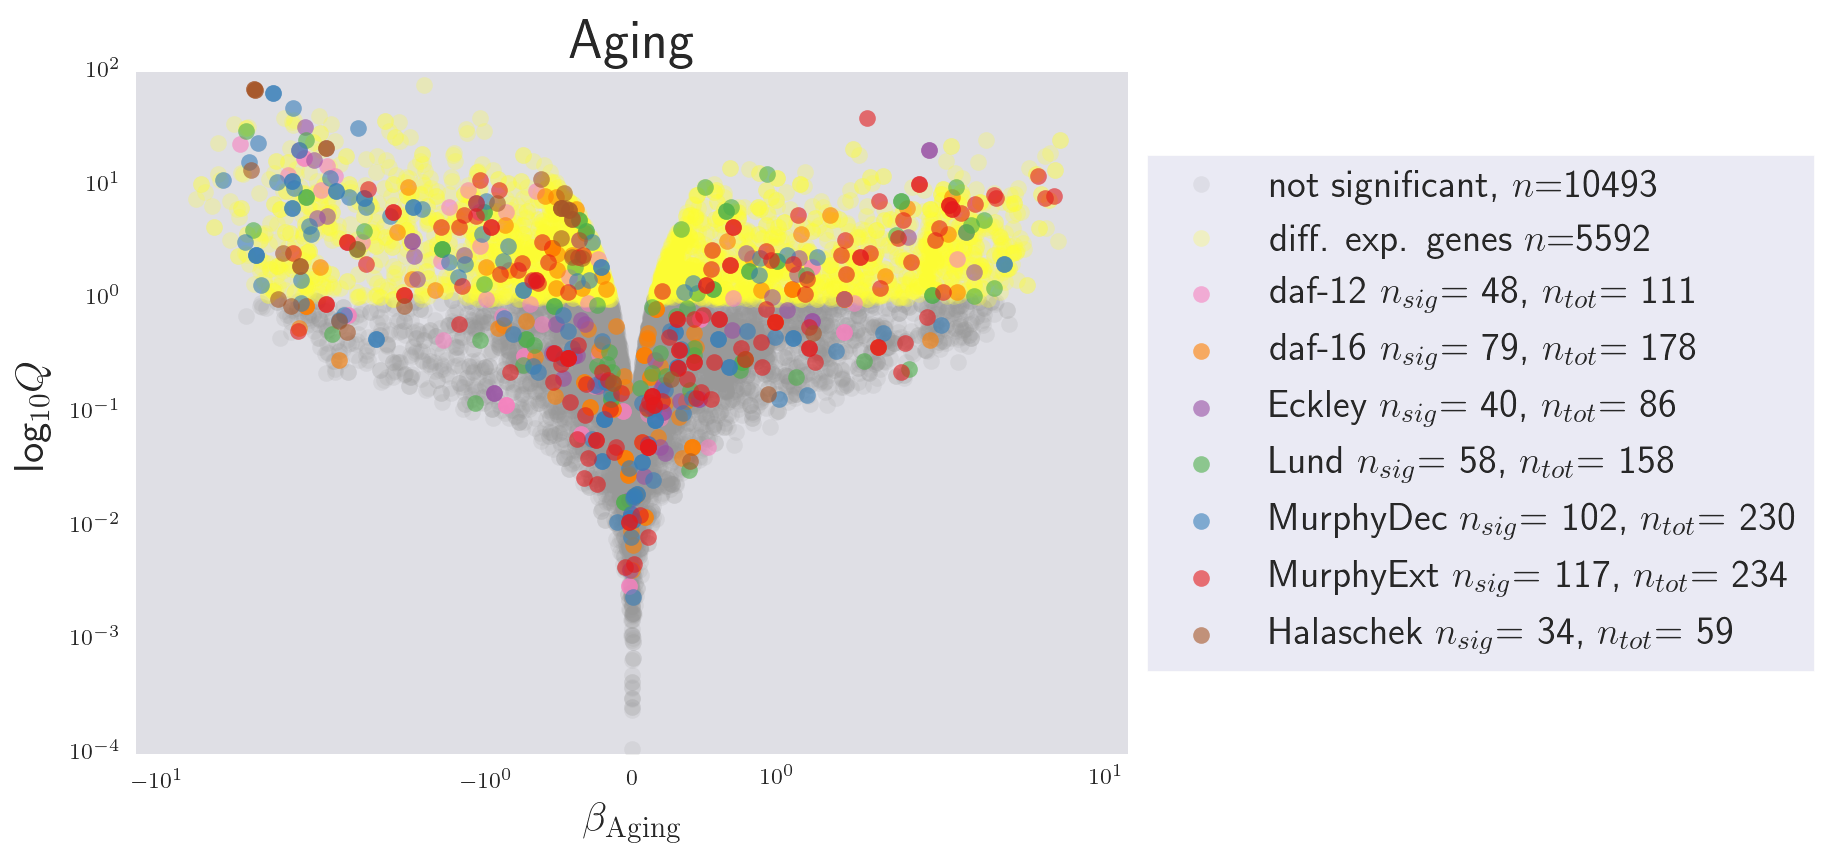

In [16]:
colors = ['#999999', '#ffff33', '#f781bf', '#ff7f00',
          '#984ea3', '#4daf4a', '#377eb8', '#e41a1c', '#a65628']

rsq.explode_cool_genes(qval, 'b', 'qval', 'origin', 'gene', dfBetaA,
                       dfGoldStandard, colors=colors, title='Aging',
                       xlab=r'$\beta_{\mathrm{Aging}}$', xlim=[-12, 12],
                       ylim=[10**-4, 10**2], downsample=0.5)


# Figure out aging set quality via a hypergeometric test

In [17]:
sig = (dfBetaA.qval < 0.1)
gold = (dfBetaA.ens_gene.isin(dfGoldStandard.gene))
found = dfBetaA[sig & gold].shape[0]
pval = stats.hypergeom.sf(found, dfBetaA.shape[0], dfGoldStandard.shape[0], dfBetaA[sig].shape[0])
s = 'There are {0} gold standard genes in the aging set. '
s += 'This number is enriched above background at a p-value of {1:.2g}'
print(s.format(found, pval))

There are 512 gold standard genes in the aging set. This number is enriched above background at a p-value of 8.1e-39


# Volcano Plots

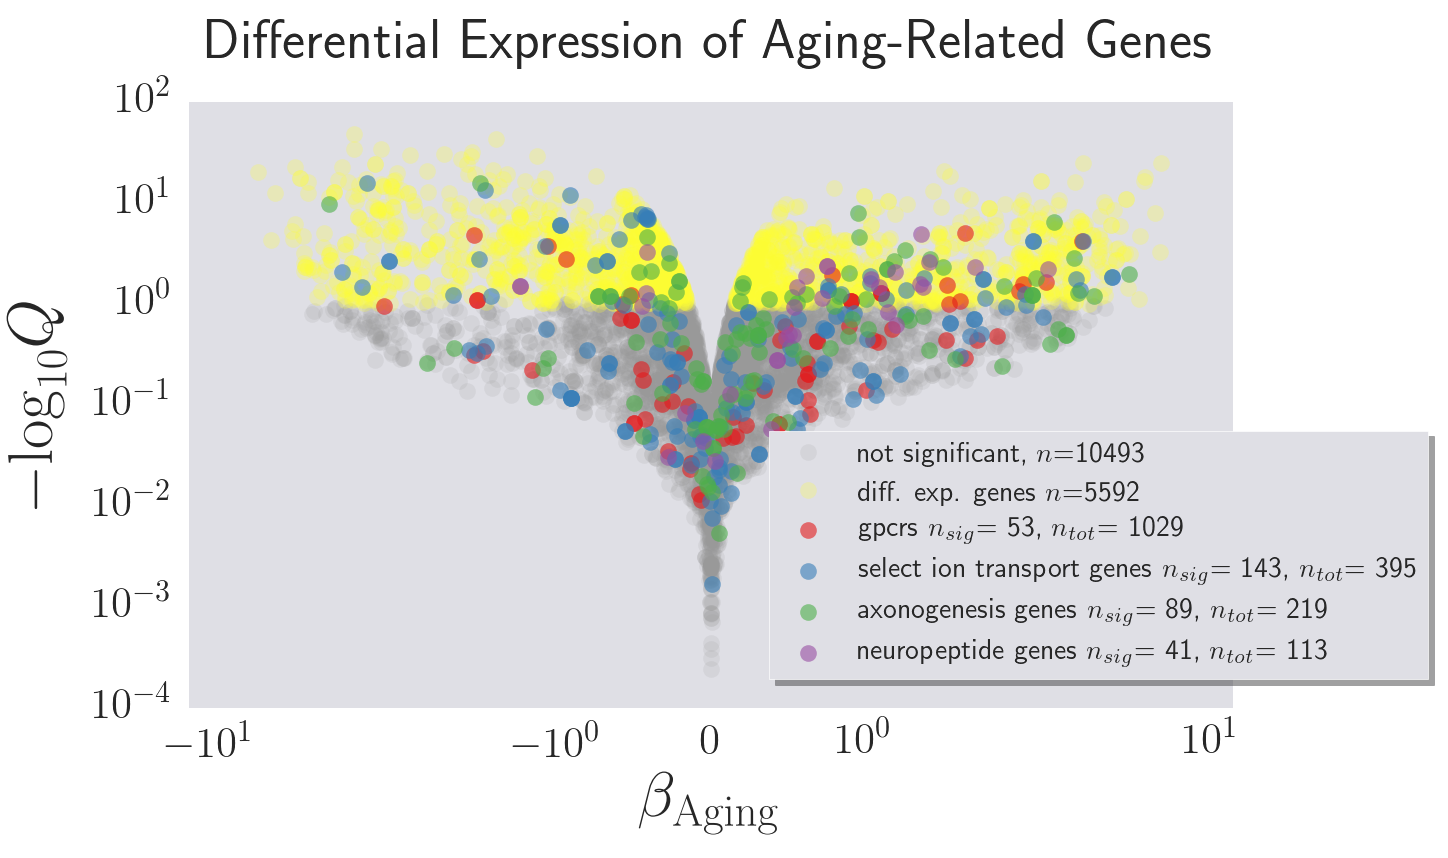

In [18]:
colors = ['#999999', '#ffff33', '#e41a1c',
          '#377eb8', '#4daf4a', '#984ea3', 
          '#984ea3', '#984ea3', '#984ea3']
x = 'b'
y = 'qval'
targ_x = 'effect'
targ_y = 'gene'
fig, ax = rsq.explode_cool_genes(qval, x, y, targ_x, targ_y, dfBetaA, dfTargets,
                                 colors=colors, title='Aging',
                                 xlab=r'$\beta_{\mathrm{Aging}}$', xlim=[-12, 12],
                                 ylim=[10**-4, 10**2], downsample=0.3)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=xticksize)
plt.ylabel(u'$-\mathrm{log}_{10}Q$', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
plt.xlabel(r'$\beta_{\mathrm{Aging}}$', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
ax.legend(bbox_to_anchor=(1.2, .48), frameon=True, fontsize=volcano_legendsize, shadow=True)
title = plt.title('Differential Expression of Aging-Related Genes', y=1.05)
plt.tight_layout()
plt.savefig(output_aging + 'volcano_plot_aging.svg', transparent=False, bbox_inches='tight')

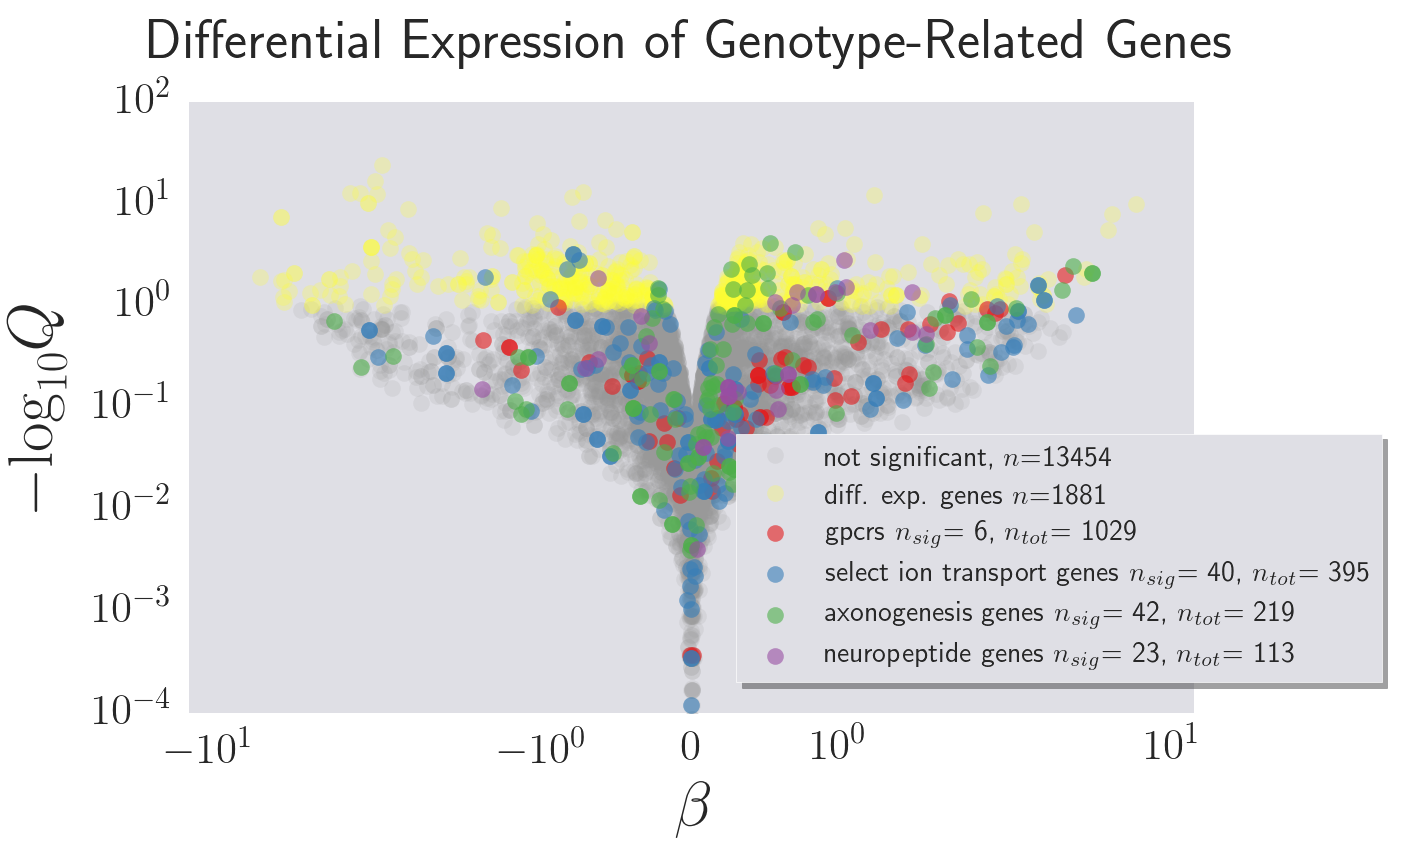

In [19]:
colors = ['#999999', '#ffff33', '#e41a1c',
          '#377eb8', '#4daf4a', '#984ea3', 
          '#984ea3', '#984ea3', '#984ea3']
x = 'b'
y = 'qval'
targ_x = 'effect'
targ_y = 'gene'
fig, ax = rsq.explode_cool_genes(qval, x, y, targ_x, targ_y, dfBetaG, dfTargets,
                                 colors=colors, title='Aging',
                                 xlab=r'$\beta_{\mathrm{Aging}}$', xlim=[-12, 12],
                                 ylim=[10**-4, 10**2], downsample=0.3)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=xticksize)
plt.ylabel(u'$-\mathrm{log}_{10}Q$', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
plt.xlabel(r'$\beta$', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
ax.legend(bbox_to_anchor=(1.2, .48), frameon=True, fontsize=volcano_legendsize, shadow=True)
title = plt.title('Differential Expression of Genotype-Related Genes', y=1.05)
plt.tight_layout()
plt.savefig(output_genotype + 'volcano_plot_genotype.svg', transparent=False)

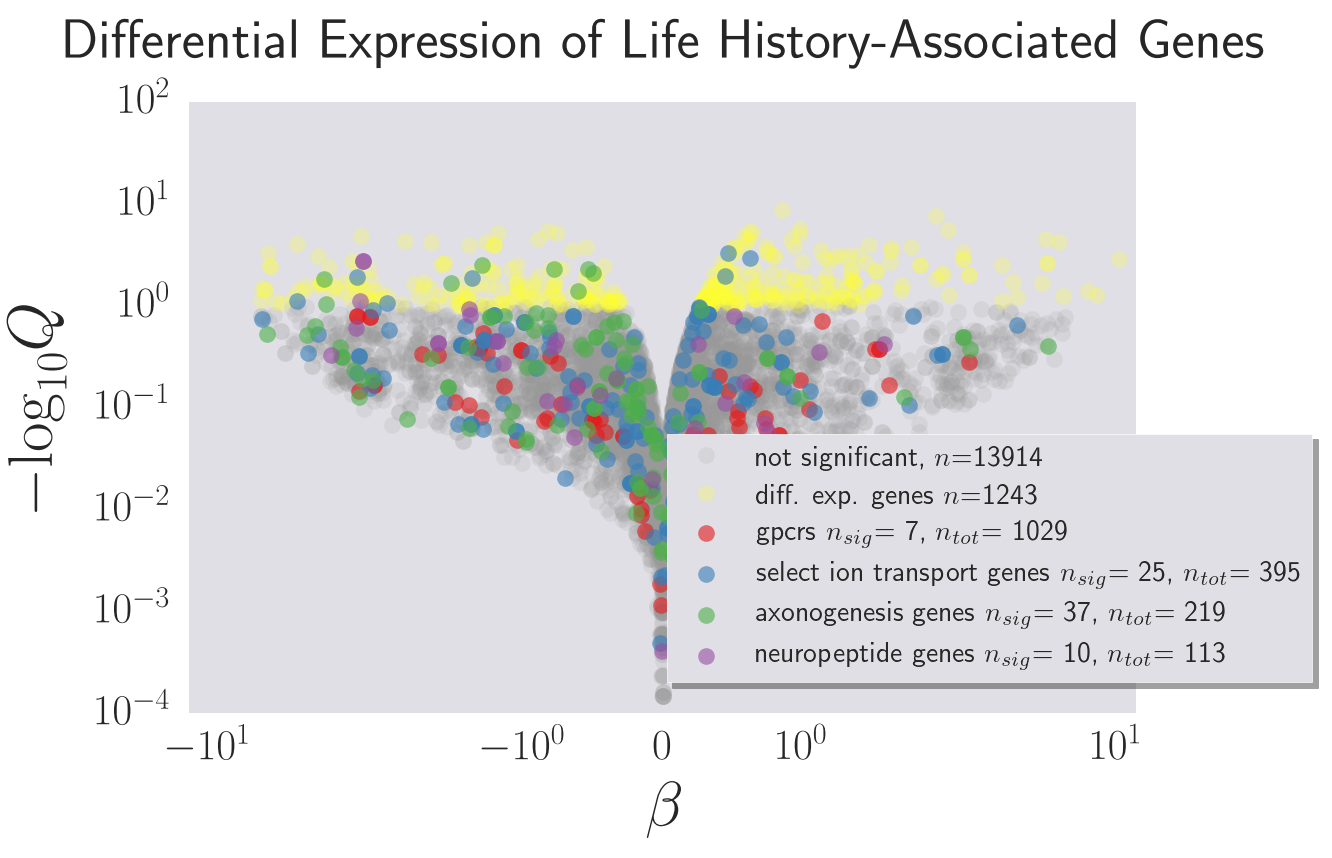

In [20]:
colors = ['#999999', '#ffff33', '#e41a1c',
          '#377eb8', '#4daf4a', '#984ea3', 
          '#984ea3', '#984ea3', '#984ea3']
x = 'b'
y = 'qval'
targ_x = 'effect'
targ_y = 'gene'
fig, ax = rsq.explode_cool_genes(qval, x, y, targ_x, targ_y, dfBetaAG, dfTargets,
                                 colors=colors, title='Aging::Genotype',
                                 xlab=r'$\beta_{\mathrm{Aging::Genotype}}$', xlim=[-12, 12],
                                 ylim=[10**-4, 10**2], downsample=0.3)
plt.xticks(fontsize=xticksize)
plt.yticks(fontsize=xticksize)
plt.ylabel(u'$-\mathrm{log}_{10}Q$', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
plt.xlabel(r'$\beta$', fontsize=xlabelsize).set_path_effects([path_effects.Normal()])
ax.legend(bbox_to_anchor=(1.2, .48), frameon=True,
          fontsize=volcano_legendsize, shadow=True).set_path_effects([path_effects.Normal()])
title = plt.title('Differential Expression of Life History-Associated Genes',
                  y=1.05).set_path_effects([path_effects.Normal()])
plt.tight_layout()

for i, label in enumerate(ax.get_xticklabels()):
    ax.get_xticklabels()[i].set_path_effects([path_effects.Normal()])
for i, label in enumerate(ax.get_yticklabels()):
    ax.get_yticklabels()[i].set_path_effects([path_effects.Normal()])

plt.savefig(output_interaction + 'volcano_plot_interaction.pdf', transparent=False, bbox_inches='tight')


(<matplotlib.figure.Figure at 0x11e5829e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11a363be0>)

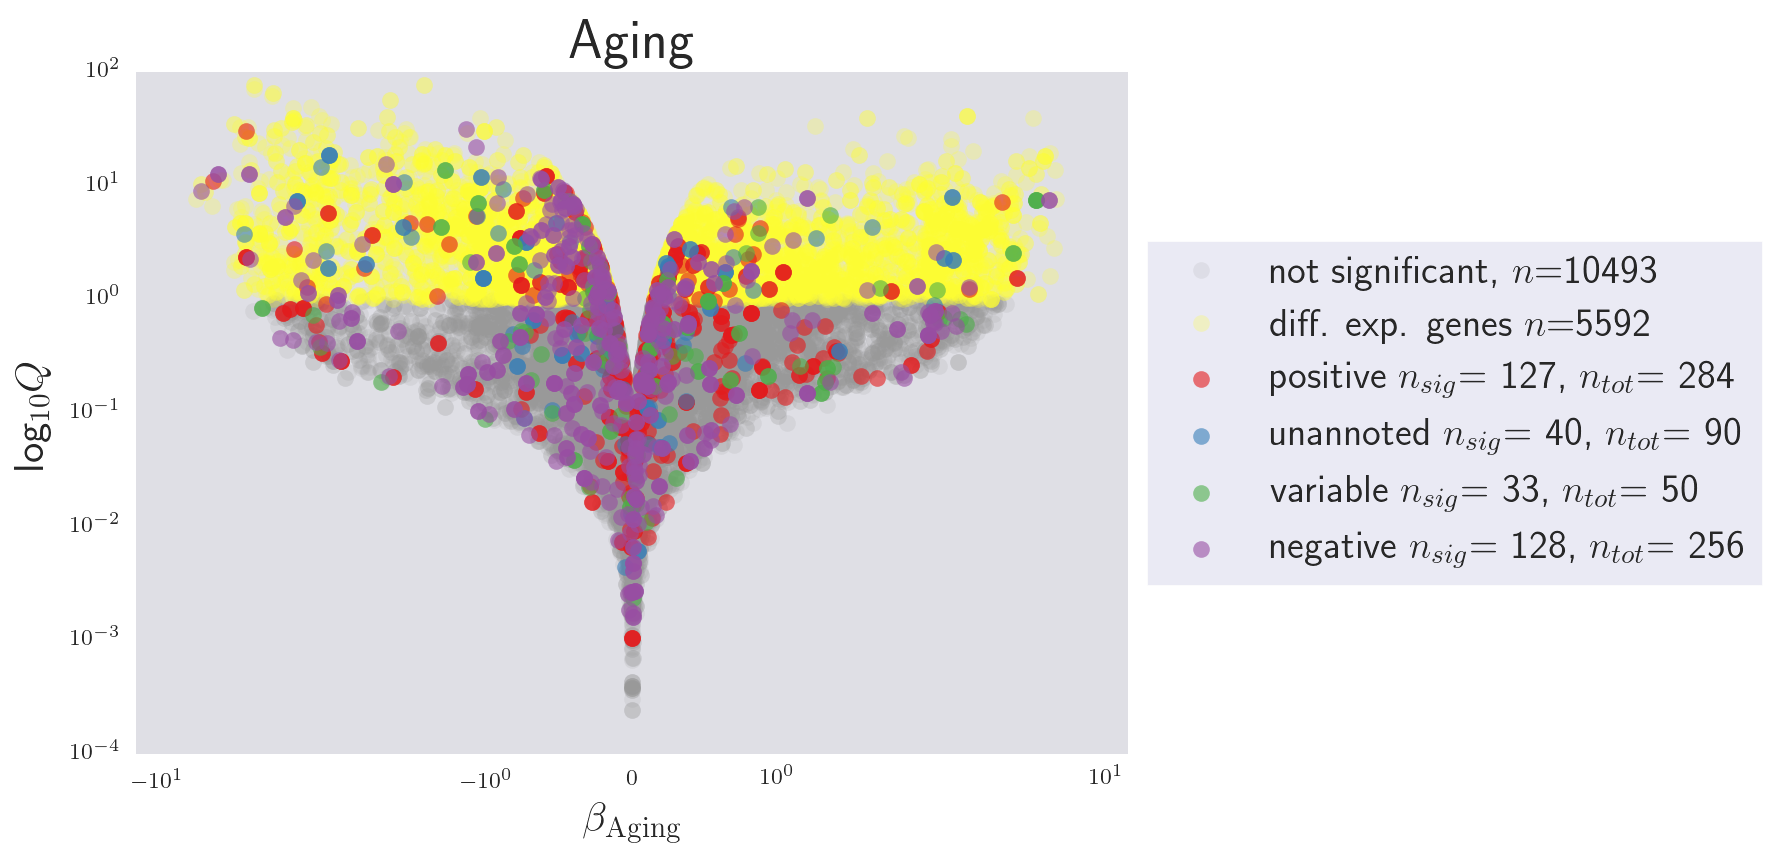

In [21]:
colors = ['#999999', '#ffff33', '#e41a1c',
          '#377eb8', '#4daf4a', '#984ea3']
x = 'b'
y = 'qval'
targ_x = 'effect'
targ_y = 'gene'
rsq.explode_cool_genes(qval, x, y, targ_x, targ_y, dfBetaA, dfLifespanGenes,
                       colors=colors, title='Aging',
                       xlab=r'$\beta_{\mathrm{Aging}}$', xlim=[-12, 12],
                       ylim=[10**-4, 10**2])
# plt.ylabel(u'log$_{10}Q$').set_path_effects([path_effects.Normal()])
# plt.xlabel(u'\beta').set_path_effects([path_effects.Normal()])



(<matplotlib.figure.Figure at 0x118108358>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11f2d8748>)

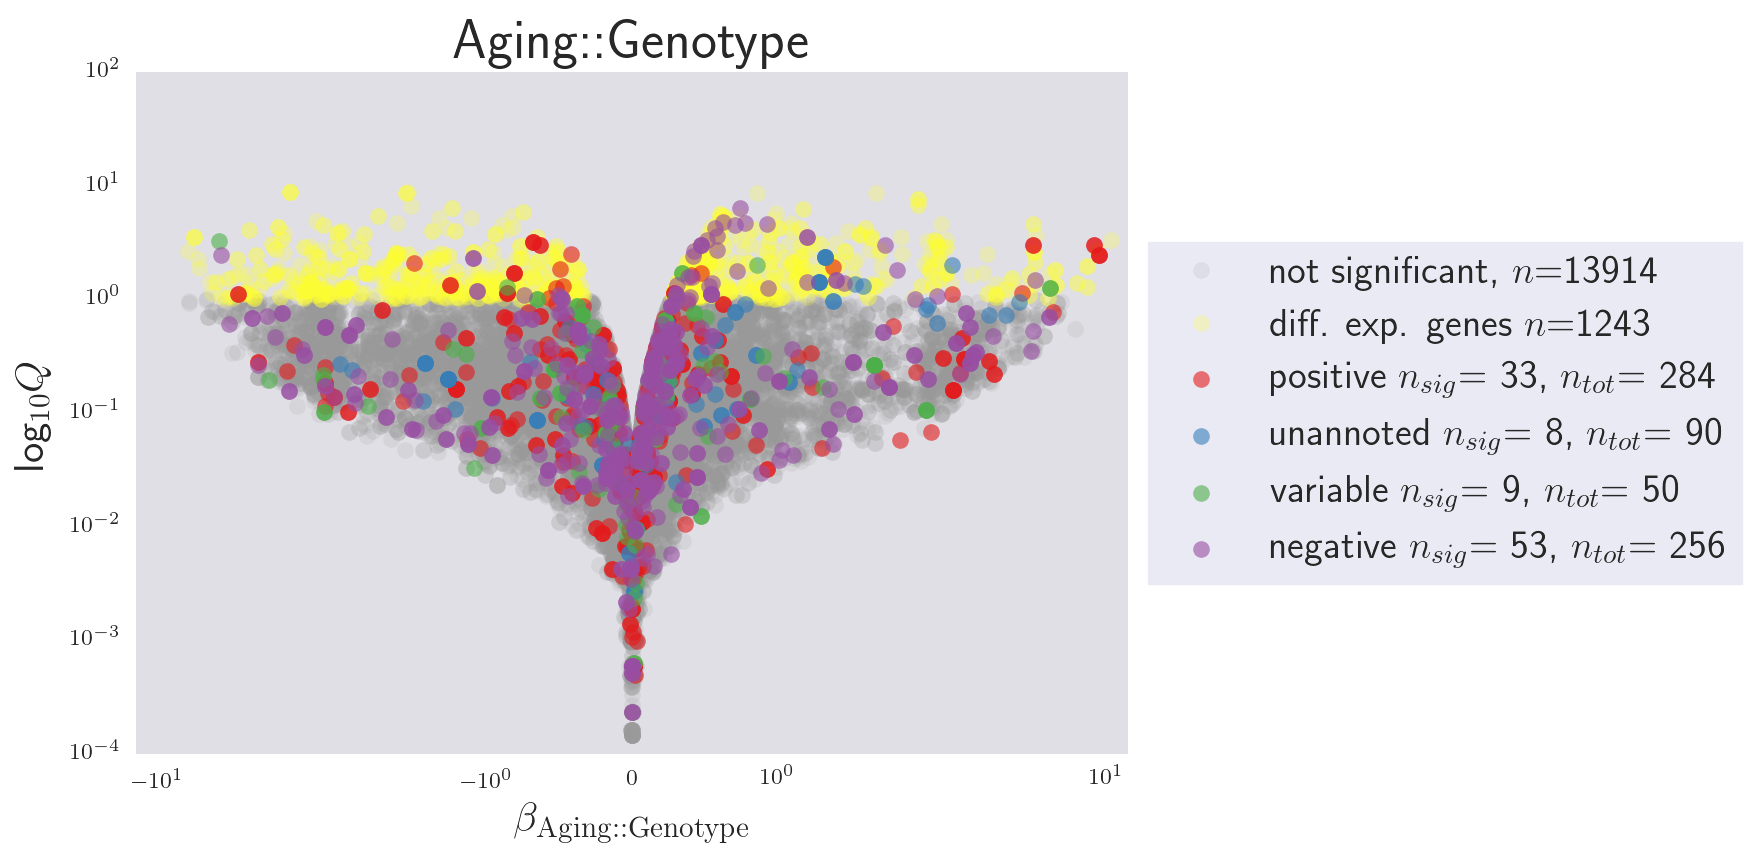

In [22]:
rsq.explode_cool_genes(qval, x, y, targ_x, targ_y, dfBetaAG, dfLifespanGenes,
                       colors=colors, title='Aging::Genotype',
                       xlab=r'$\beta_{\mathrm{Aging::Genotype}}$',
                       xlim=[-12, 12], ylim=[10**-4, 10**2])

# RNAi Screen Sets

In [23]:
def exclude(df, excluded_genes, col):
    ind = (~df[col].isin(excluded_genes))
    return df[ind]


def find_molecular_targets(df, to_be_removed, cols='ens_gene', x='b', q=0.1):
    """
    Given a dataframe df, return a new dataframe that:
    Doesn't have WBIDs present in the exclude series
    Has only genes that have q value < qval
    """
    if cols in [str, int, float]:
        cols = [cols]

    df.sort_values(x, inplace=True)
    sig = (df.qval < q)  # take only sig genes

    temp = df[sig].copy()  # remove all non-sig genes and make a temp copy
    if isinstance(to_be_removed, list):
        for i, excluded_gene_list in enumerate(to_be_removed):
            temp = exclude(temp, excluded_gene_list, cols[i])
    return temp


In [24]:
# set the path to sve the rnai candidates
# and make sure to exclude known genes from analysis
path = '../output/RNAi Candidates/'
excluded1 = pd.Series(dfLifespanGenes.gene.append(dfGoldStandard.gene).unique())
# =============================================================================
# =============================================================================
# also exclude genes that have significant betas in any other list
x = dfBetaG[dfBetaG.qval < qval].target_id
y = dfBetaAG[dfBetaAG.qval < qval].target_id
excluded2 = pd.Series(x.append(y).unique())
excluded = [excluded1, excluded2]
cols = ['ens_gene', 'target_id']

aging_set = find_molecular_targets(dfBetaA, excluded, cols, q=qval)
aging_set.to_csv('../output/AgingGeneSet.csv')
aging_set.tail(55).to_csv(path + 'CandidatesAge_HighInOld.csv')
aging_set.head(55).to_csv(path + 'CandidatesAge_LowInOld.csv')
# =============================================================================
# =============================================================================
# now for genotype, same thing
x = dfBetaA[dfBetaA.qval < qval].target_id
y = dfBetaAG[dfBetaAG.qval < qval].target_id
excluded2 = pd.Series(x.append(y).unique())
excluded = [excluded1, excluded2]
genotype_set = find_molecular_targets(dfBetaG, excluded, cols, q=qval)
genotype_set.to_csv('../output/GenotypeGeneSet.csv')
genotype_set.tail(55).to_csv(path + 'CandidatesGenotype_HighInOld.csv')
genotype_set.head(55).to_csv(path + 'CandidatesGenotype_LowInOld.csv')

# interactions
# more than linear increase in age, up in fog2 more than wt
# only take genes that go way up during age
ind = (dfBetaA.ix[dfBetaAG[dfBetaAG.qval < qval].index].b >
       dfBetaA.b.quantile(.99))
ind2 = (dfBetaAG.target_id.isin(dfLRT[dfLRT.qval < qval].target_id))
interaction_set = dfBetaAG[(dfBetaAG.qval < qval) & ind2].copy()

selection = dfBetaA.ens_gene.isin(interaction_set.ens_gene.values)
xxx = dfBetaA[(dfBetaA.qval < qval) & (selection)].ens_gene

yyy = interaction_set[interaction_set.ens_gene.isin(xxx)].copy()
yyy.sort_values('b', inplace=True)
# interaction_set.sort_values('b', inplace=True)
yyy.head(20).to_csv('../output/RNAi Candidates/CandidatesAgingXGenotypeMoreThanExp.csv')
yyy.tail(20).to_csv('../output/RNAi Candidates/CandidatesAgingXGenotypeLessThanExp.csv')


# Identifying Transcription Factors Involved

In [25]:
ind1 = (dfBetaA.qval < qval)
ind2 = (dfBetaA.target_id.isin(tf.target_id))
inds = ind1 & ind2
x = dfBetaA[inds].sort_values('qval')
print(x.shape)

(145, 15)


In [26]:
ind1 = (dfBetaG.qval < qval)
ind2 = (dfBetaG.target_id.isin(tf.target_id))
inds = ind1 & ind2
y = dfBetaG[inds].sort_values('qval')
print(y.shape)

(60, 15)


In [27]:
ind1 = (dfBetaAG.qval < qval)
ind2 = (dfBetaAG.target_id.isin(tf.target_id))
inds = ind1 & ind2
z = dfBetaAG[inds].sort_values('qval')
print(z.shape)

(36, 15)


In [28]:
print('Aging Results:')
resA, _ = tea.enrichment_analysis(x.ens_gene, tissue_df, show=False)
print('\n-------------\nGenotype Results:')
resG, _ = tea.enrichment_analysis(y.ens_gene, tissue_df, show=False)
print('\n-------------\nAging::Genotype Results:')
resAG, _ = tea.enrichment_analysis(z.ens_gene, tissue_df, show=False)

l = len('WBbt:0005829')
resA.Tissue = resA.Tissue.map(lambda x: str(x)[:-l-1])
resG.Tissue = resG.Tissue.map(lambda x: str(x)[:-l-1])
resAG.Tissue = resAG.Tissue.map(lambda x: str(x)[:-l-1])
resA[(resA.Expected > 1)  & (resA.Observed > 2)][['Tissue', 'Expected', 'Observed', 'Q value']]

Aging Results:
Executing script


-------------
Genotype Results:
Executing script


-------------
Aging::Genotype Results:
Executing script



Tissue   Expected  Observed   Q value
36    dorsal nerve cord   5.177866        19  0.000006
99   ventral nerve cord   9.011858        26  0.000006
102                 P11   1.146245         9  0.000006
48          head muscle   3.498024        13  0.000040
125                P7.p   1.422925         6  0.001382
43                 P8.p   1.284585         5  0.004231
3                  P5.p   1.403162         5  0.006541
14                 P6.p   1.422925         5  0.006956
105                 HSN   2.134387         6  0.011528
104                P3.p   1.264822         4  0.016868
72                 P4.p   1.264822         4  0.016868
13       nervous system  58.913043        69  0.027257
94                  AVA   1.007905         3  0.034623
15                 hyp4   1.047431         3  0.039082
17                  PQR   1.106719         3  0.046530
28                vulB2   1.126482         3  0.048938

In [29]:
resG[(resG.Expected > 1)  & (resG.Observed > 2)][['Tissue', 'Expected', 'Observed', 'Q value']]

Tissue   Expected  Observed   Q value
126  ventral nerve cord   4.145455        18  0.000001
31    dorsal nerve cord   2.381818        10  0.000084
42          head muscle   1.609091         6  0.002162
18       nervous system  27.100000        34  0.022843
108     coelomic system   1.618182         4  0.042647

In [30]:
resAG[(resAG.Expected > 1)  & (resAG.Observed > 2)][['Tissue', 'Expected', 'Observed', 'Q value']]

Tissue  Expected  Observed   Q value
44  ventral nerve cord  2.343083        10  0.001619
13   dorsal nerve cord  1.346245         7  0.002624

# Overlap between datasets

In [39]:
ind1 = (dfBetaA.qval < 0.1)
ind2 = (dfBetaG.qval < 0.1)
intersect = dfBetaA[ind1 & ind2]

In [40]:
intersect.ens_gene.unique().shape

(1040,)

In [41]:
dfBetaG[ind2].ens_gene.unique().shape

(1881,)

In [42]:
dfBetaA[ind1].ens_gene.unique().shape

(5592,)

In [45]:
ind3 = dfBetaA.b*dfBetaG.b > 0
coexpressed = dfBetaA[(ind1) & (ind2) & (ind3)]

In [46]:
coexpressed.ens_gene.unique().shape

(905,)

# Bokeh Plots
## Volcano Plots

In [47]:
def make_expression_axes(tooltips, title,
                          xlabel, ylabel):
    """A function to plot the bokeh single mutant comparisons."""
    # Make the hover tool
    hover = bokeh.models.HoverTool(tooltips=tooltips,
                                   names=['circles'])

    # Create figure
    p = bokeh.plotting.figure(title=title, plot_width=650, 
                              plot_height=450)

    p.xgrid.grid_line_color = 'white'
    p.ygrid.grid_line_color = 'white'
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel

    # Add the hover tool
    p.add_tools(hover)
    return p


def add_points(p, df, x, y, se_x, color='blue', alpha=0.2, outline=False):
    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    source1 = bokeh.models.ColumnDataSource(df)

    transformed_q = -df[y].apply(np.log)
    # Specify data source
    p.circle(x=x, y=transformed_q, size=7,
             alpha=alpha, source=source1,
             color=color, name='circles')
    if outline:
        p.circle(x=x, y=transformed_q, size=7,
                 alpha=1,
                 source=source1, color='black',
                 fill_color=None, name='outlines')

    # prettify
    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    
    return p

def selector(df):
    """A function to separate tfs from everything else"""
    sig = (df.qval < 0.1)# & (dfBetaA.b.abs() > 0.5)
    not_tf = (~df.target_id.isin(tf.target_id))
    is_tf = (df.target_id.isin(tf.target_id))
    to_plot_not = df[sig & not_tf]
    to_plot_yes = df[sig & is_tf]
    return to_plot_not, to_plot_yes

In [48]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

p = make_expression_axes( tooltips, 'Aging Volcano Plot', 'Beta Coefficient (log-fold change)', '-log(Q)')

to_plot_not, to_plot_yes = selector(dfBetaA)

p = add_points(p, to_plot_not, 'b', 'qval', 'se_b', color='gray')
p = add_points(p, to_plot_yes, 'b', 'qval', 'se_b', color='green', alpha=0.6, outline=True)

html = file_html(p, CDN, "my plot")
HTML(html)

In [49]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

p = make_expression_axes( tooltips, 'Genotype Volcano Plot', 'Beta Coefficient (log-fold change)', '-log(Q)')

to_plot_not, to_plot_yes = selector(dfBetaG)

p = add_points(p, to_plot_not, 'b', 'qval', 'se_b', color='gray')
p = add_points(p, to_plot_yes, 'b', 'qval', 'se_b', color='green', alpha=0.6, outline=True)

html = file_html(p, CDN, "my plot")
HTML(html)

In [50]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

p = make_expression_axes( tooltips, 'Aging::Genotype Volcano Plot', 'Beta Coefficient (log-fold change)', '-log(Q)')

to_plot_not, to_plot_yes = selector(dfBetaAG)

p = add_points(p, to_plot_not, 'b', 'qval', 'se_b', color='gray')
p = add_points(p, to_plot_yes, 'b', 'qval', 'se_b', color='green', alpha=0.6, outline=True)

html = file_html(p, CDN, "my plot")
HTML(html)

In [51]:
def compare_points(p, df1, df2, b='b', q='qval', se_b='se_b', color='blue',
                   alpha=0.2, outline=False, threshold=50):
    """A function to plot the b values between two dataframes against each other"""
    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    source1 = bokeh.models.ColumnDataSource(df1)

    transformed_q = -df1[q].apply(np.log)
    transformed_q[transformed_q > threshold] = threshold

    cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))
            ]
    # Specify data source
    p.circle(x=df1[b], y=df2[b], size=7,
             alpha=alpha, source=source1,
             color=cols, name='circles')

    if outline:
        p.circle(x=df1[b], y=df2[b], size=8,
                 alpha=1, fill_color=None,
                 color='red', source=source1)

    # prettify
    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    
    return p

def rectangle(p, top1, bottom1, left1, right1, top2, bottom2, left2, right2):
    """Plots a rectangle."""
    p.quad(top=top1, bottom=bottom1, left=left1,
       right=right1, color="#7e7e7e", alpha=0.8)
    p.quad(top=top2, bottom=bottom2, left=left2,
       right=right2, color="#7e7e7e", alpha=0.8)
    return p

## Cross Plots

In [52]:
# sort by target_id
dfBetaA.sort_values('target_id', inplace=True)
dfBetaA.reset_index(inplace=True)
dfBetaG.sort_values('target_id', inplace=True)
dfBetaG.reset_index(inplace=True)
dfBetaAG.sort_values('target_id', inplace=True)
dfBetaAG.reset_index(inplace=True)
dfLRT.sort_values('target_id', inplace=True)
dfLRT.reset_index(inplace=True)

In [53]:
indA = dfBetaA.target_id.isin(intersect.target_id)
indG = dfBetaG.target_id.isin(intersect.target_id)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene')]

p = make_expression_axes( tooltips, 'Aging vs Genotype Volcano Plot',
                         'Beta Coefficient (Aging)', 'Beta Coefficient (Genotype)')

p = rectangle(p, 7, 0.01, -6, -0.01, -7, -0.01, 0.01, 6)

to_plot_notA, to_plot_yesA = selector(dfBetaA[indA])
to_plot_notG, to_plot_yesG = selector(dfBetaG[indG])

p = compare_points(p, to_plot_notA, to_plot_notG, 'b', 'qval', 'se_b', color='gray', alpha=0.5)
p = compare_points(p, to_plot_yesA, to_plot_yesG, 'b', 'qval', 'se_b', color='gray', alpha=0.7, outline=True)

p.line([-6, 6], [-6, 6], line_width=1, color='black')
p.line([-6, 6], [0, 0], line_width=1, color='black', line_dash=(4,4))
p.line([0, 0], [-6, 6], line_width=1, color='black', line_dash=(4,4))

html = file_html(p, CDN, "my plot")
HTML(html)

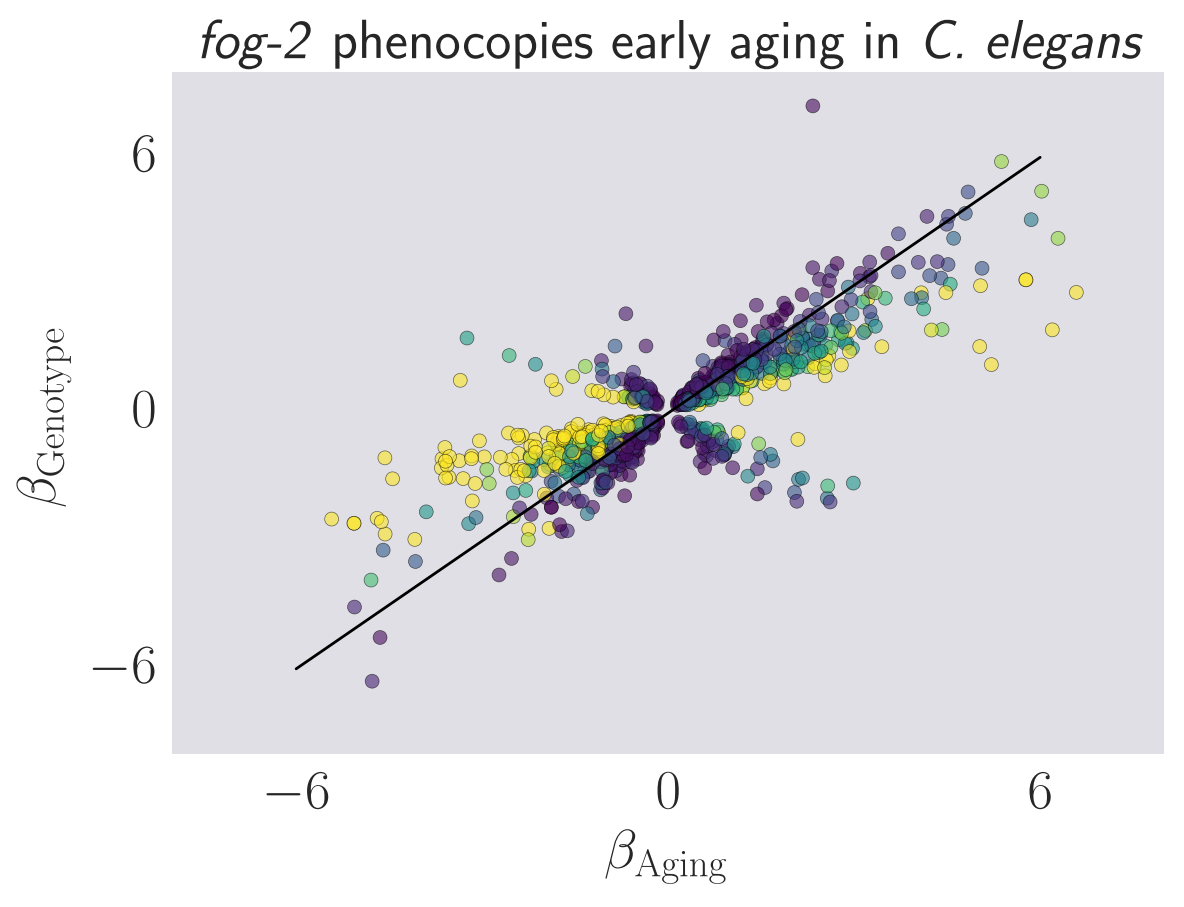

In [54]:
threshold = 20
transformed_q = -to_plot_notA.qval.apply(np.log)
transformed_q[transformed_q > threshold] = threshold

cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))]

plt.scatter(to_plot_notA.b, to_plot_notG.b, c=transformed_q, cmap='viridis', alpha=0.6, s=25)

x = np.linspace(-6, 6)
plt.plot(x, x, 'k-', lw=1)
plt.xticks([-6, 0, 6], fontsize=20)
plt.yticks([-6, 0, 6], fontsize=20)
plt.xlabel(r'$\beta_\mathrm{Aging}$', fontsize=20).set_path_effects([path_effects.Normal()])
plt.ylabel(r'$\beta_\mathrm{Genotype}$', fontsize=20).set_path_effects([path_effects.Normal()])
title = r'\emph{fog-2} phenocopies early aging in \emph{C. elegans}'
plt.title(title).set_path_effects([path_effects.Normal()])

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    ax.get_xticklabels()[i].set_path_effects([path_effects.Normal()])
for i, label in enumerate(ax.get_yticklabels()):
    ax.get_yticklabels()[i].set_path_effects([path_effects.Normal()])


plt.savefig('../output/fog2phenocopiesaging.pdf', bbox_inches='tight')

In [55]:
inag = dfBetaAG[dfBetaAG.qval < 0.1].target_id
ina = dfBetaA[dfBetaA.qval < 0.1].target_id
ing = dfBetaG[dfBetaG.qval < 0.1].target_id

ind1 = (dfBetaA.target_id.isin(inag)) & (dfBetaA.qval < 0.1) & (dfBetaA.target_id.isin(ing))
ind2 = (dfBetaAG.qval < 0.1) & (dfBetaAG.target_id.isin(ina)) & (dfBetaAG.target_id.isin(ing))

to_plot_not1, to_plot_yes1 = selector(dfBetaA[ind1])
to_plot_not2, to_plot_yes2 = selector(dfBetaAG[ind2])

p = make_expression_axes( tooltips, 'Aging vs Aging::Genotype Plot',
                         'Beta Coefficient (Aging)', 'Beta Coefficient (Aging::Genotype)')

p = rectangle(p, 10, 0.1, -10, -0.01, -10, -0.01, 0.01, 10)
p = compare_points(p, to_plot_not1, to_plot_not2, 'b', 'qval', 'se_b', color='gray', alpha=0.5)

p = compare_points(p, to_plot_yes1, to_plot_yes2, 'b', 'qval', 'se_b', color='gray', alpha=0.7, outline=True)

p.line([-10, 10], [10, -10], line_width=1, color='black')
p.line([-10, 10], [0, 0], line_width=1, color='black', line_dash=(4,4))
p.line([0, 0], [-10, 10], line_width=1, color='black', line_dash=(4,4))

html = file_html(p, CDN, "my plot")
HTML(html)

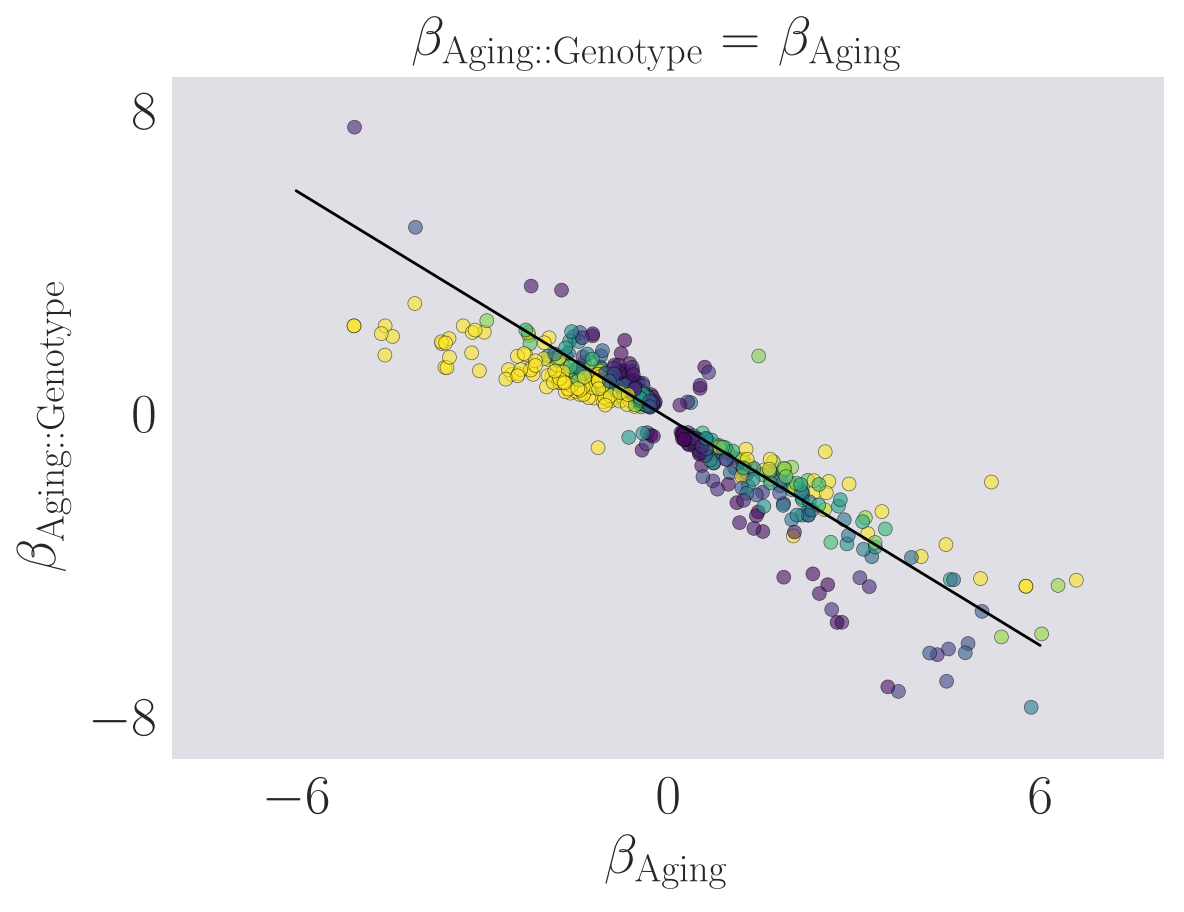

In [56]:
threshold = 20
transformed_q = -to_plot_not1.qval.apply(np.log)
transformed_q[transformed_q > threshold] = threshold

cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))]

plt.scatter(to_plot_not1.b, to_plot_not2.b, c=transformed_q, cmap='viridis', alpha=0.6, s=25)
x = np.linspace(-6, 6)
plt.plot(x, -x, 'k-', lw=1)
plt.xticks([-6, 0, 6], fontsize=20)
plt.ylim(-9, 9)
plt.yticks([-8, 0, 8], fontsize=20)
plt.xlabel(r'$\beta_\mathrm{Aging}$', fontsize=20).set_path_effects([path_effects.Normal()])
plt.ylabel(r'$\beta_\mathrm{Aging::Genotype}$', fontsize=20).set_path_effects([path_effects.Normal()])
plt.title(r'$\beta_\mathrm{Aging::Genotype}$ = $\beta_\mathrm{Aging}$').set_path_effects([path_effects.Normal()])

ax = plt.gca()
for i, label in enumerate(ax.get_xticklabels()):
    ax.get_xticklabels()[i].set_path_effects([path_effects.Normal()])
for i, label in enumerate(ax.get_yticklabels()):
    ax.get_yticklabels()[i].set_path_effects([path_effects.Normal()])

plt.savefig('../output/aginggenotype_vs_aging.pdf', bbox_inches='tight')

In [57]:
ind1 = (dfBetaG.target_id.isin(inag)) & (dfBetaG.qval < 0.1) & (dfBetaG.target_id.isin(ina))
ind2 = (dfBetaAG.qval < 0.1) & (dfBetaAG.target_id.isin(ina)) & (dfBetaAG.target_id.isin(ing))

to_plot_not1, to_plot_yes1 = selector(dfBetaG[ind1])
to_plot_not2, to_plot_yes2 = selector(dfBetaAG[ind2])

p = make_expression_axes( tooltips, 'Genotype vs Aging::Genotype Plot',
                         'Beta Coefficient (Genotype)', 'Beta Coefficient (Aging::Genotype)')

p = rectangle(p, 10, 0.1, -10, -0.01, -10, -0.01, 0.01, 10)

p = compare_points(p, to_plot_not1, to_plot_not2, 'b', 'qval', 'se_b', color='gray', alpha=0.5)
p = compare_points(p, to_plot_yes1, to_plot_yes2, 'b', 'qval', 'se_b', color='gray', alpha=0.7, outline=True)

p.line([-10, 10], [10, -10], line_width=1, color='black')
html = file_html(p, CDN, "my plot")
HTML(html)

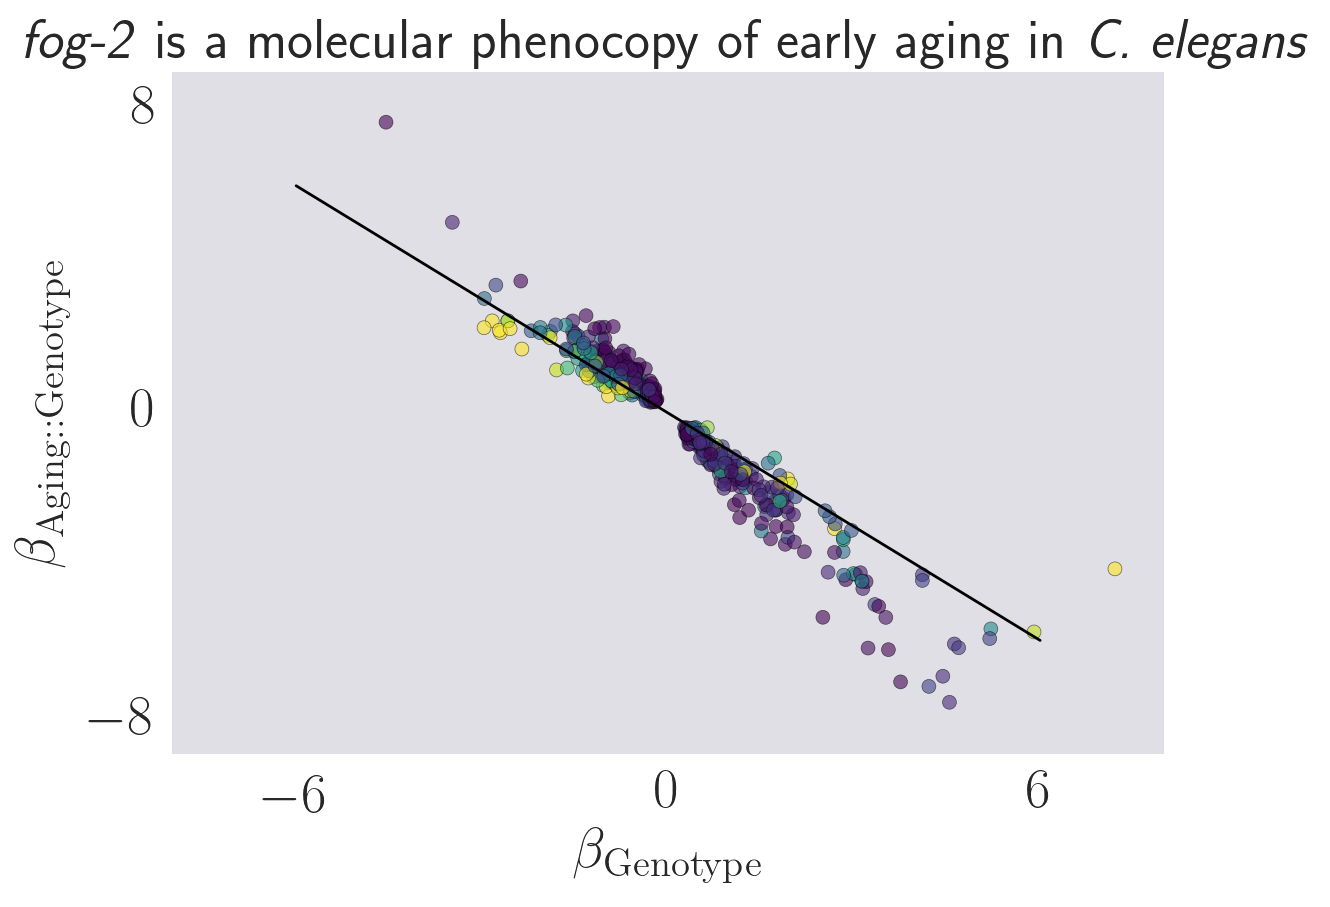

In [58]:
transformed_q = -to_plot_not1.qval.apply(np.log)
transformed_q[transformed_q > threshold] = threshold

plt.scatter(to_plot_not1.b, to_plot_not2.b, c=transformed_q, cmap='viridis', alpha=0.6, s=25)
x = np.linspace(-6, 6)
plt.plot(x, -x, 'k-', lw=1)
plt.xticks([-6, 0, 6], fontsize=20)
plt.ylim(-9, 9)
plt.yticks([-8, 0, 8], fontsize=20)
plt.xlabel(r'$\beta_\mathrm{Genotype}$', fontsize=20)
plt.ylabel(r'$\beta_\mathrm{Aging::Genotype}$', fontsize=20)
plt.title(r'\emph{fog-2} is a molecular phenocopy of early aging in \emph{C. elegans}')
plt.savefig('../output/aginggenotype_vs_genotype.pdf', bbox_inches='tight')

In [59]:
dfBetaA[dfBetaA.qval < 0.1].ens_gene.unique().shape

(5592,)